In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
import pickle
import numpy as np
from gensim.models import Word2Vec

# Import data

In [2]:
data = pd.read_csv("restaurant-food.csv")

In [3]:
counts = pd.DataFrame(data['Restaurant'].value_counts())
counts.reset_index(inplace=True)

data = data.merge(counts, left_on='Restaurant', right_on='index')
data.drop(['index'], axis=1, inplace=True)
data.columns = ['Restaurant', 'Food','Counts']
data.head(10)

,Restaurant,Food,Counts
0,/babasan-by-uncle-kiisu,"beer,fruit",4
1,/babasan-by-uncle-kiisu,rice,4
2,/babasan-by-uncle-kiisu,"crispy pork,mee siam,pork,pork belly",4
3,/babasan-by-uncle-kiisu,"fish,fish roe,rice,roe,seafood,unagi",4
4,/yobo,"brown rice,cream,pumpkin,rice,salad",4
5,/yobo,"aglio olio,brussel sprout,fusilli,mushroom,nut...",4
6,/yobo,"brown rice,chicken,cream,kale chip,rice",4
7,/yobo,"chicken,cream,kale chip,pumpkin,soy,soy chicken",4
8,/enjoy-eating-house-and-bar,"cream,fish,fruit,meat,nut,otah,prawn,rice,seaf...",90
9,/enjoy-eating-house-and-bar,"broth,earl,mushroom,vermicelli",90


# Data Cleaning

In [4]:
# Take in restaurants with more than 10 reviews. Need a min number of reviews.
data = data[(data['Counts']>10)]
data.shape

(33823, 3)

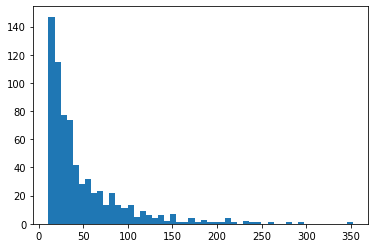

In [5]:
# See distribution of reviews 
D = data['Restaurant'].value_counts()
plt.hist(D, bins=50)
plt.show()

In [6]:
# Text cleaning
data['Restaurant'] = data['Restaurant'].apply(lambda x: x.lstrip("/"))
data.head()

,Restaurant,Food,Counts
8,enjoy-eating-house-and-bar,"cream,fish,fruit,meat,nut,otah,prawn,rice,seaf...",90
9,enjoy-eating-house-and-bar,"broth,earl,mushroom,vermicelli",90
10,enjoy-eating-house-and-bar,"crab,crab meat,egg,fish,fish soup,meat,pork,po...",90
11,enjoy-eating-house-and-bar,"egg,hor fun,mushroom,noodle,pork,prawn,rice,ta...",90
12,enjoy-eating-house-and-bar,"chilli,chilli crab,crab,crab sauce,egg,prawn,t...",90


In [7]:
# Get mapping dict to map synonyms to a single term (e.g. tze char --> zi char). 
# Local food especially, have > 1 way of being spelled
mapping = pd.read_excel('mapping.xlsx')
mapping.columns=["X","Y"]
map_dict = {}
for i in range(mapping.shape[0]):
    x = mapping.iloc[i,0]
    y = mapping.iloc[i,1]
    map_dict[x] = y

In [8]:
# Init the restaurant dict "compiled"
# "Compiled" is a dict of {'RESTAURANT_NAME': [list, of, food, served]}

compiled = {R: list([]) for R in data['Restaurant'].unique()}

for i in range(data.shape[0]):
    restaurant = data.iloc[i,0]
    food = data.iloc[i,1]
    food = food.split(',')
    
    compiled[restaurant].extend(food)

In [9]:
# Use the above mapping to Standardize terms (apply the "map_dict" to "compiled")
for k, v in compiled.items():
    for i,food in enumerate(v):
        if food in map_dict.keys():
            compiled[k][i]= map_dict[food]

In [10]:
# Remove subsets ("beef, wagyu beef" --> "wagyu beef") and Remove foods that appear too frequently
stoplist = "soysauce egg yam friedchicken aldente porkbelly earlgrey seafood berries sandwich spinach scallop pancake chocolate yoghurt jelly shake tomato potato meat pasta bacon tart apple beans turkey beef vegetable cake salad beer berry caffeine pho cucumber steak fruit date chestnut bread broth rice bun burger butter carrot cheese chicken chilli sauce clam cocoa coffee cookie corn crab cream curry custard dessert drink duck egg fish fries herbs lamb lard lemon lettuce milk mutton mushroom nut noodle papaya pie pineapple pork prawn raisin pumpkin ribs rice roe soy stew strawberry tea tuna truffle vinegar wing wine banana".split()

for k, v in compiled.items():
    for i, food_1 in enumerate(v):
        for j, food_2 in enumerate(v):
            a = food_1
            b = food_2
            if a == b:
                continue
            elif set(a).issubset(set(b)):
                compiled[k][i]=''
            if a in stoplist:
                compiled[k][i]=''
    compiled[k] = list(set(compiled[k]))
    
    if '' in compiled[k]:
        compiled[k].remove('')

# Create Graph

We create a bi-partite graph consisting of [Restaurant]--serves-->[Food]

In [11]:
# Make graph
G=nx.Graph()

for k, v in compiled.items():
    G.add_node(k, attribute = 'restaurant')
    for food in v:
        G.add_node(food, attribute = 'food')
        G.add_edge(k,food,relation = 'serves')

We create a corpus of "sentences" that comprise random walks through the graph.

In [12]:
# Make the string
def getString(node, depth):
    
    if depth == 0:
        return  node
    
    neighbours = list(G.neighbors(node))
    
    next_node = random.choice(neighbours)
    
    return node + ',' + getString(next_node, depth-1) 

# Make the corpus
def getCorpus(graph, depth, repeat):
    
    corpus = []
    
    # For each node
    for node in graph.nodes:
        
        # repeat
        for i in range(repeat):
            
            instance = getString(node, depth).split(',')
            
            corpus.append(instance)
            
    return corpus

# Create text corpus
# depth = length of each sentence
# repeat = number of sentences generated starting from each restaurant node
text = getCorpus(graph=G, depth=50, repeat=500)

# Train the model

In [19]:
# Train model
dim = 50
model = Word2Vec(text, size=dim, window=1, min_count=20, sg=1)

# Extract the "restaurant" embeddings

In [20]:
# Get restaurant vectors
restaurant_list = list(data['Restaurant'].unique())

restaurant_arr = np.ones((len(restaurant_list), dim))

for i, restaurant in enumerate(restaurant_list):
    
    restaurant_arr[i] = model[restaurant]


C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# Create labels

Here, we generate a table containing the restaurant names, and the food that people commented on. We use this table to manually generate cuisine labels using the exported excel file.

In [21]:
# Create lables

output = []

for R in restaurant_list:
    
    temp = [R, compiled[R]]
    output.append(temp)
    
output = pd.DataFrame(output)

# Export the file to be manually labeled
# output.to_excel('for_labelling.xlsx')

After manually labelling the restaurants, we import the excel file in again, and use it to train our classifier.

In [22]:
labels = pd.read_excel('labels.xlsx')

labels.drop([1], axis=1, inplace=True)

labels = labels['Label'].tolist()

# Create table

In [23]:
data = pd.DataFrame(restaurant_arr)
data['Label'] = labels
data['Restaurant'] = restaurant_list
data.shape

(697, 52)

Total of 697 restaurants and 52 columns (50 embedding cols, 1 restaurant name, 1 label column)

In [24]:
with open("node_data.pkl",'wb') as f:
    pickle.dump(data, f)

In [26]:
text[3]

['enjoy-eating-house-and-bar',
 'chendol',
 'basil-thai-kitchen-1',
 'soft shell crab',
 'spize-at-temasek-club-rifle-range-road',
 'basil leave',
 'enjoy-eating-house-and-bar',
 'yam paste',
 'chinatown-complex-market-food-centre',
 'black bean',
 'vatos-urban-tacos-2',
 'craft beer',
 'the-coconut-club',
 'craft beer',
 'cottontail-creamery',
 'scrambled egg',
 'the-butchers-wife',
 'asparagus',
 'pizzaexpress-singapore',
 'basil',
 'clinton-street-baking-company-singapore',
 'flat white',
 'gridscircles',
 'thick toast',
 'dutch-colony-coffee-co-1',
 'wrap',
 'ji-xiangang-ku-kueh',
 'orh nee',
 'enjoy-eating-house-and-bar',
 'fish soup',
 'chinatown-complex-market-food-centre',
 'vermicelli',
 'wok-master',
 'red bean',
 'bedok-85-market',
 'tze char',
 'wee-nam-kee-hainanese-chicken-rice-restaurant',
 'water chestnut',
 'beach-road-scissor-cut-curry-rice',
 'chilli sauce',
 'fook-kin',
 'wanton mee',
 'fei-fei-wanton-mee',
 'wanton mee',
 'dumpling-darlings',
 'gyoza',
 'ikura-japa